In [503]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords

In [504]:
retail = pd.read_csv('exercise2_input.csv', encoding = 'iso-8859-1')
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 8 columns):
RowID          9994 non-null int64
OrderID        9994 non-null object
OrderDate      9994 non-null object
CustomerID     9994 non-null object
ProductID      9994 non-null object
ProductName    9994 non-null object
Sales          9994 non-null float64
Quantity       9994 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 624.7+ KB


In [505]:
#Check for missing values
def checking_na(df):
    try:
        if (isinstance(df, pd.DataFrame)):
            df_na_bool = pd.concat([df.isnull().any(), df.isnull().sum(), (df.isnull().sum()/df.shape[0])*100],
                                   axis=1, keys=['df_bool', 'df_amt', 'missing_ratio_percent'])
            df_na_bool = df_na_bool.loc[df_na_bool['df_bool'] == True]
            return df_na_bool
        else:
            print("{}: The input is not panda DataFrame".format(now()))

    except (UnboundLocalError, RuntimeError):
        print("{}: Something is wrong".format(now()))

df = checking_na(retail)
if df.empty:
    print('Data is healthy and does not have any missing data.')
else:
    print(df)

Data is healthy and does not have any missing data.


In [506]:
retail.dtypes

RowID            int64
OrderID         object
OrderDate       object
CustomerID      object
ProductID       object
ProductName     object
Sales          float64
Quantity         int64
dtype: object

In [507]:
retail['OrderDate'] = pd.to_datetime(retail['OrderDate'])
print('Dataframe dimensions:', retail.shape)

Dataframe dimensions: (9994, 8)


In [508]:
retail.head(5)

,RowID,OrderID,OrderDate,CustomerID,ProductID,ProductName,Sales,Quantity
0,1,CA-2016-152156,2016-08-11,CG-12520,FUR-BO-10001798,Bush Somerset Collection Bookcase,261.9600,2
1,2,CA-2016-152156,2016-08-11,CG-12520,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3
2,3,CA-2016-138688,2016-12-06,DV-13045,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,14.6200,2
3,4,US-2015-108966,2015-11-10,SO-20335,FUR-TA-10000577,Bretford CR4500 Series Slim Rectangular Table,957.5775,5
4,5,US-2015-108966,2015-11-10,SO-20335,OFF-ST-10000760,Eldon Fold 'N Roll Cart System,22.3680,2


In [509]:
retail = retail.drop(columns=['RowID']) #Drop RowId as its not necessary

In [510]:
retail.describe() #only shows float and int columns

,Sales,Quantity
count,9994.000000,9994.000000
mean,229.858001,3.789574
std,623.245101,2.225110
min,0.444000,1.000000
25%,17.280000,2.000000
50%,54.490000,3.000000
75%,209.940000,5.000000
max,22638.480000,14.000000


In [511]:
print(retail['CustomerID'].nunique()) #Unique Customers
print(retail['ProductName'].nunique()) #Unique Product IDs out of a total order of 9994

793
1850


Check if there are any duplicate rows: 
For same order id if all the rows are duplicate, then it may be an incorrect order

In [512]:
duplicateRowsDF = retail[retail.duplicated(keep=False)]
duplicateRowsDF

,OrderID,OrderDate,CustomerID,ProductID,ProductName,Sales,Quantity
3405,US-2014-150119,2014-04-23,LB-16795,FUR-CH-10002965,Global Leather Highback Executive Chair with P...,281.372,2
3406,US-2014-150119,2014-04-23,LB-16795,FUR-CH-10002965,Global Leather Highback Executive Chair with P...,281.372,2


Since there is one row which is duplicated, we can check the order details to know more about the order.

In [513]:
retail[retail.OrderID.str.startswith('US-2014-150119')] 

,OrderID,OrderDate,CustomerID,ProductID,ProductName,Sales,Quantity
3405,US-2014-150119,2014-04-23,LB-16795,FUR-CH-10002965,Global Leather Highback Executive Chair with P...,281.372,2
3406,US-2014-150119,2014-04-23,LB-16795,FUR-CH-10002965,Global Leather Highback Executive Chair with P...,281.372,2
3407,US-2014-150119,2014-04-23,LB-16795,OFF-BI-10000145,Zipper Ring Binder Pockets,7.488,8
3408,US-2014-150119,2014-04-23,LB-16795,FUR-FU-10002191,G.E. Halogen Desk Lamp Bulbs,22.336,4


The quanity of the product 'Global Leather Highback Executive Chair' should be 4 or it is a duplicated record. 
It looks like it is a duplicate record as the e-commerce system would have recognized that its the same product and should have added the quantity to 4 while creating the order. Hence I would drop the record. 

In [514]:
retail = retail.drop_duplicates(keep='first').reset_index()

Check if there are any blank customers or zero or negative quantity, zero or negative price

In [515]:
#Orders with blank customers
print('Orders with blank customers: ' + str(retail[retail['CustomerID'].isnull()].shape[0]))
#Orders that have zero or negative quantity
print('Orders that have zero or negative quantity: ' + str(retail[(retail['Quantity'] <= 0)].shape[0]))
#Orders that have zero or negative price
print('Orders that have zero or negative price: ' + str(retail[(retail['Sales'] <= 0)].shape[0]))

Orders with blank customers: 0
Orders that have zero or negative quantity: 0
Orders that have zero or negative price: 0


In [516]:
#Check the type of products since FUR, OFF and TEC are repeated which are the first 3 characters
retail['ProductCategory'] = retail['ProductID'].str[:3] 
#Check the sub type of products since FUR, OFF and TEC are repeated which are the first 5th and 6th characters
retail['ProductSubCategory'] = retail['ProductID'].str[4:6] 
print(retail.ProductCategory.unique())
print(retail.ProductSubCategory.unique())

['FUR' 'OFF' 'TEC']
['BO' 'CH' 'LA' 'TA' 'ST' 'FU' 'AR' 'PH' 'BI' 'AP' 'PA' 'AC' 'EN' 'FA'
 'SU' 'MA' 'CO']


In [517]:
cat = retail.groupby('ProductCategory') #Group by Product Category and check the type of sub category it has
subcat = cat.apply(lambda x: x['ProductSubCategory'].unique())
subcat

ProductCategory
FUR                        [BO, CH, TA, FU]
OFF    [LA, ST, AR, BI, AP, PA, EN, FA, SU]
TEC                        [PH, AC, MA, CO]
dtype: object

In [518]:
#for better understanding rename the values of Category
retail = retail.replace({'ProductCategory' : { 'FUR' : 'FURNITURE', 'OFF' : 'OFFICE ACCESSORIES', 'TEC' : 'TECHNOLOGY' }})

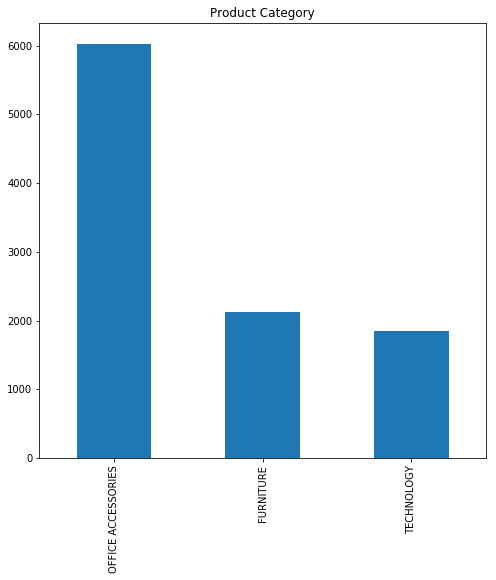

In [519]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
retail.ProductCategory.value_counts().plot(kind='bar', title="Product Category", ax=ax, figsize=(8,8))
plt.show()

Similarly, if we need to understand what are the different product subcategories, we can filter and understand from the product names

In [520]:
from collections import Counter 
dfta = retail[retail.ProductSubCategory.str.contains('BO')]
most_occur = Counter(" ".join(dfta['ProductName']).split()).most_common(5)
print(most_occur) # It appears that BO sub category means Book Cases

[("O'Sullivan", 67), ('Finish', 66), ('Bookcases,', 64), ('Bookcases', 59), ('Collection', 58)]


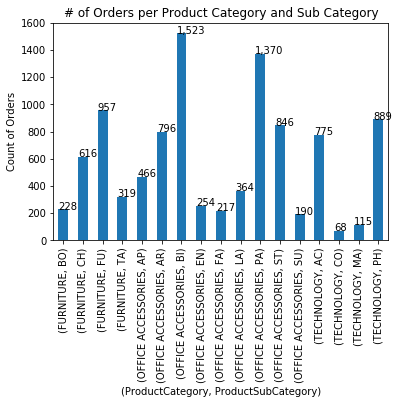

In [521]:
ax = retail.groupby(['ProductCategory', 'ProductSubCategory']).size().plot(kind='bar')
ax.set_title("# of Orders per Product Category and Sub Category")
ax.set_xlabel("(ProductCategory, ProductSubCategory)")
ax.set_ylabel("Count of Orders")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1))

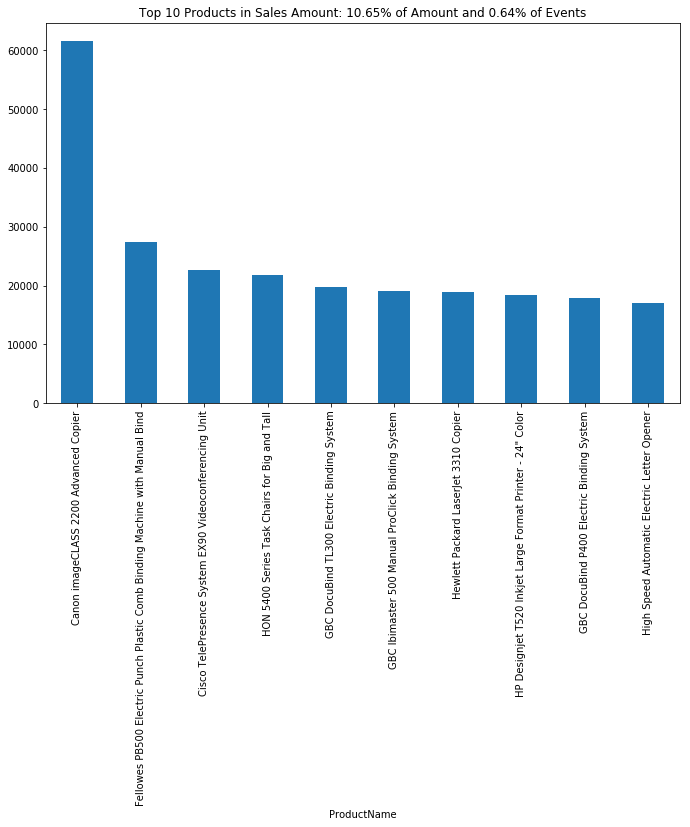

In [522]:
SalesSum = retail.groupby(["ProductName"]).Sales.sum().sort_values(ascending = False)
invSales = retail[["ProductName", "OrderID"]].groupby(["ProductName"]).OrderID.unique().\
      agg(np.size).sort_values(ascending = False)
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(SalesSum[:10].index)
PercentSales =  np.round((SalesSum[Top10].sum()/SalesSum.sum()) * 100, 2)
PercentEvents = np.round((invSales[Top10].sum()/invSales.sum()) * 100, 2)
g = SalesSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

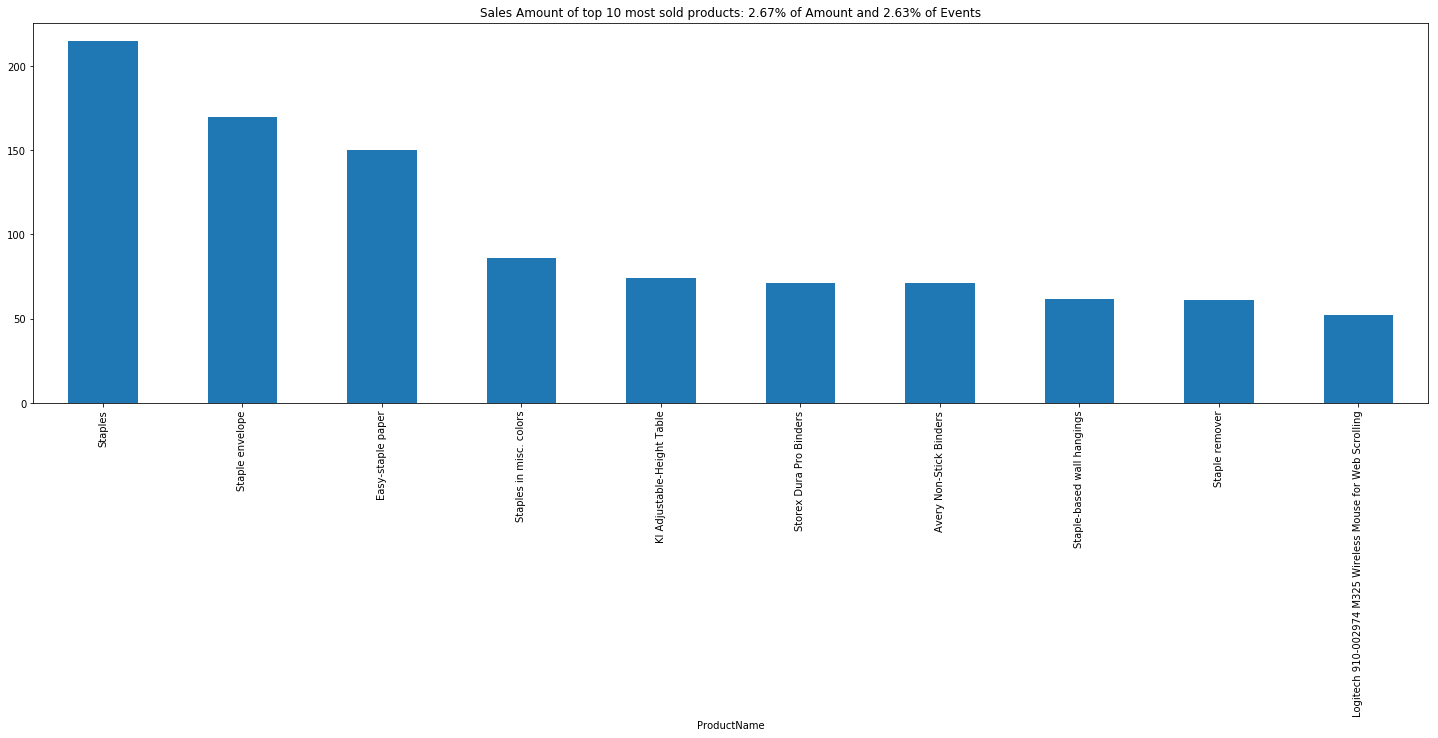

In [523]:
QtySum = retail.groupby(["ProductName"]).Quantity.sum().sort_values(ascending = False)
invQty = retail[["ProductName", "OrderID"]].groupby(["ProductName"]).OrderID.unique().\
      agg(np.size).sort_values(ascending = False)
fig = plt.figure(figsize=(25, 7))
Top10ev = list(invQty[:10].index)

PercentSales =  np.round((QtySum[Top10ev].sum()/QtySum.sum()) * 100, 2)
PercentEvents = np.round((invQty[Top10ev].sum()/invQty.sum()) * 100, 2)
g = QtySum[Top10ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

# Clean and Generalize Product Names

Initially, I used len(sample_text.split()) <= 2 as there are many products such as Newell 322, Avery 49 etc 
which if we parse using logic of POS tag to keep only Nouns, then we are left with blanks.
I decided to use CD as well for products like Xerox which has many differnet products named 'Xerox <num>'


New Update after doing Market Basket Analysis in SQL: I realized the need to generalize the product names some more.
I decided to remove the numbers from the products like Newell 322, Avery 49 etc 
Hence I removed CD from products like Xerox which has many differnet products named 'Xerox <num>'

In [524]:
# Do pre-processing: Tokenization, Lemmatization
def nltk_process(sample_text):
    #word tokenizer, but it includes the punctuation
    #tokenizing words using RegexpTokenizer of nltk, which by default removes all punctuation.
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized = tokenizer.tokenize(sample_text)
    #tokenized = word_tokenize(sample_text)    
    stop_words = stopwords.words('english')
    words = [word for word in tokenized if word not in stop_words]
    #sent = ' '.join([w for w in words])
    #converted each word to its root word using WordNetLemmatizer of nltk.
    lemma = WordNetLemmatizer()
    #lemma_words = ' '.join([lemma.lemmatize(w) for w in words]) #tokenized]) 
    #print(len(sample_text.split()))
    pnames = ''
    #pnames = ' '.join([w for w in word_tokenize(lemma_words)]) 
    #Get pos_tag of words and we are only interested in Nouns and numbers as there is certain products with numbers
    for wd in words:
        lemma_word = lemma.lemmatize(wd)
        
        t  = pos_tag(word_tokenize(lemma_word))
        #print(t[0][1])
        #for w, t in pos_tag(word_tokenize(lemma_words)):      
        
        if t[0][1] in ['NN','NNS', 'NNP', 'NNPS']: #len(sample_text.split()) <= 2 
            pnames = pnames + lemma_word + ' ' 

    #print(pnames)
    return pnames.strip()
#nltk_process('Global Leather Highback Executive Chair with')

In [525]:
retail['GenProductName'] = retail['ProductName'].apply(nltk_process)

After verifying in SQL, I am able to generate the Market Basket Analysis.
But with this where condition: Support >= 0.2 and Confidence >= 0.6 and Lift > 1 
it doesnot return me results and hence I need to work more on generalizing the product names 
Next approach: Keep Top 5% of words most frquently used is another additional way to generalize product names

In [526]:
#commenting the below approach I didnot use it in the final results
'''lst = pd.Series(' '.join(retail['ProductName']).lower().split()).value_counts()[:500]
def keepcommonwords(sample):
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized = tokenizer.tokenize(sample)
    pnames = ''
    #print(tokenized)
    for word in tokenized:
        if word.lower() in lst:
            #print(word)
            pnames = pnames + word + ' '            
    if pnames == '':
        return sample.strip()
    else:
        return pnames.strip()
retail['GenProductName'] = retail['GenProductName'].apply(keepcommonwords)
#This didnot increase the support and I understood I need to generalise the product more'''

"lst = pd.Series(' '.join(retail['ProductName']).lower().split()).value_counts()[:500]\ndef keepcommonwords(sample):\n    tokenizer = RegexpTokenizer(r'\\w+')\n    tokenized = tokenizer.tokenize(sample)\n    pnames = ''\n    #print(tokenized)\n    for word in tokenized:\n        if word.lower() in lst:\n            #print(word)\n            pnames = pnames + word + ' '            \n    if pnames == '':\n        return sample.strip()\n    else:\n        return pnames.strip()\nretail['GenProductName'] = retail['GenProductName'].apply(keepcommonwords)\n#This didnot increase the support and I understood I need to generalise the product more"

After verifying in SQL, I am able to generate the Market Basket Analysis.
But with this where condition: Support >= 0.2 and Confidence >= 0.6 and Lift > 1 
Hence another way to generalize the product name: As observed, the last 2 words signify more about the product, hence to generalise the products more. But without brands, the product becomes more common, hence I would keep the first word for brand and the last 2 words for product.

In [527]:
#commenting the below approach I didnot use it in the final results
'''def first1last2words(text):
    if len(text.split()) > 3:
        x = text.lower().split()
        s = len(x)
        text = x[0] + ' ' + x[s-2] + ' ' + x[s-1]
    return text
retail['GenProductName'] = retail['GenProductName'].apply(first1last2words)'''

"def first1last2words(text):\n    if len(text.split()) > 3:\n        x = text.lower().split()\n        s = len(x)\n        text = x[0] + ' ' + x[s-2] + ' ' + x[s-1]\n    return text\nretail['GenProductName'] = retail['GenProductName'].apply(first1last2words)"

After verifying in SQL, I am able to generate the Market Basket Analysis.
But with this where condition: Support >= 0.2 and Confidence >= 0.6 and Lift > 1 
Hence another way to generalize the product name: As observed, the last 2 words signify more about the product, hence to generalise the products more. I would remove the brand names and focus more on the last 2 words to get more details about the products

In [528]:
#commenting the below approach I didnot use it in the final results
'''def last2words(text):
    if len(text.split()) > 2:
        x = text.lower().split()
        s = len(x)
        text = x[s-2] + ' ' + x[s-1]
    return text
retail['GenProductName'] = retail['GenProductName'].apply(last2words)'''

"def last2words(text):\n    if len(text.split()) > 2:\n        x = text.lower().split()\n        s = len(x)\n        text = x[s-2] + ' ' + x[s-1]\n    return text\nretail['GenProductName'] = retail['GenProductName'].apply(last2words)"

For Market Basket Analysis, bestseller products are the products with the highest number of orders).
Hence we donot need the other columns. We can drop these columns - 'OrderDate','CustomerID','ProductID','Sales','Quantity'

In [529]:
retail.head()

,index,OrderID,OrderDate,CustomerID,ProductID,ProductName,Sales,Quantity,ProductCategory,ProductSubCategory,GenProductName
0,0,CA-2016-152156,2016-08-11,CG-12520,FUR-BO-10001798,Bush Somerset Collection Bookcase,261.9600,2,FURNITURE,BO,Bush Somerset Collection Bookcase
1,1,CA-2016-152156,2016-08-11,CG-12520,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,FURNITURE,CH,Hon Deluxe Fabric Chairs
2,2,CA-2016-138688,2016-12-06,DV-13045,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,OFFICE ACCESSORIES,LA,Self Address Labels Typewriters Universal
3,3,US-2015-108966,2015-11-10,SO-20335,FUR-TA-10000577,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,FURNITURE,TA,Bretford CR4500 Series Slim Table
4,4,US-2015-108966,2015-11-10,SO-20335,OFF-ST-10000760,Eldon Fold 'N Roll Cart System,22.3680,2,OFFICE ACCESSORIES,ST,Eldon Fold N Roll Cart System


In [530]:
retail = retail.drop(columns=['index','OrderDate','CustomerID','ProductID','Sales','Quantity', 'ProductName','ProductCategory','ProductSubCategory'])

Save the dataframe to a csv file to be imported to SQL Server

In [531]:
export_csv = retail.to_csv (r'C:\Users\Monu\Zalora\basket.csv', index = None, header=True)